In [48]:
import sys
sys.path.insert(0,'../libs')
import fourier as foo
import ecualizacion as equ
from matplotlib import pyplot as plt
import numpy as np
from scipy import fftpack
from scipy import misc
# import seaborn as sns
# sns.despine()
from numpy import linalg
from scipy.signal import convolve2d

In [8]:
def convolve(I, K):
    return convolve2d(I,K,mode="same")

In [2]:
def show_img(IMG):
    plt.figure(figsize=(18,10)); plt.axis('off')
    plt.imshow(IMG ,cmap='gray')
    plt.show()
    
def show_img_s(IMG, titles=None):
    img_qty = len(IMG)
    plt.figure(figsize=(18,10)); 
    for i in range(img_qty):
        plt.subplot(1,img_qty, i+1)
        if titles != None:
            plt.title(titles[i])
        plt.imshow(IMG[i] ,cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()

## Ejercicio 1

**freq_filter** toma como parámetros la imágen a filtrar, y una función de decisión. La misma, en pos de la *distancia* de una cierta amplitud para una frecuencia f al centro del espacio, decide si será removida o no.

In [ ]:
def freq_filter(img, CUTOFF_FUN):
    filtered_img = np.copy(img)
    m = len(img); n = len(img[0])
    distance = lambda i,j: np.sqrt(abs(i-m/2)**2 + abs(j-n/2)**2)
    for i in range(m):
        for j in range(n):
            if not CUTOFF_FUN(distance(i,j)):
                filtered_img[i][j] = 0
    return filtered_img

In [3]:
img = misc.imread('lena.png')

**Nota:** Si en algun momento se reodernana los cuadrantes de la imagen en el dominio de las frecuencias, antes de ser convertido por la IFFT, los mismos deben tener el mismo orden; ya sea el original, o con el el (0,0) de las frecuencias centrado en la imagen. En el *code-block* de abajo se puede ver ejemplos de ciertos filtros. En cada uno, **l** y **h** hacen referencia a los valores de corte inferior y superior.

In [ ]:
BAND_PASS_FILTER = lambda l,h: lambda d: (d <= l) or (d> h)
LOW_PASS_FILTER = lambda l: lambda d: (d <= l)
HIGH_PASS_FILTER = lambda h: lambda d: (d > h)

In [ ]:
img_F = fftpack.fft2(img)
plt.figure(figsize=(18,10))
plt.subplot(1,3,1); plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2); plt.axis('off')
# Aca ya reordeno los valores en complejo de toda la imagen (parte real e imaginaria),
# de forma de operar directamente con ellos, sin preocuparme.
img_F = foo.fix_norm_plot_regions(img_F)
img_ABS = np.abs(img_F)

# funcion de corte
CUTOFF_FUNC = HIGH_PASS_FILTER(50)
img_ABS = freq_filter(img_ABS, CUTOFF_FUNC)
plt.imshow(foo.log_transform(img_ABS), cmap='gray')
plt.subplot(1,3,3); plt.axis('off')
img_MOD = foo.assemble_complex(img_ABS, \
                               np.angle(img_F))
img_deMOD = fftpack.ifft2(img_MOD)
plt.imshow(np.abs(img_deMOD), cmap='gray')
plt.tight_layout()
plt.show()

La idea consiste en la siguiente conversión:

<p style="text-align: center;">

$\mathcal{F}(img)  \mathcal{F}(kernel) = \mathcal{F}(img_{filtered})$

$\mathcal{F}(img)^{-1}  \mathcal{F}(img)  \mathcal{F}(kernel) = \mathcal{F}(img)^{-1}  \mathcal{F}(img_{filtered})$

$\mathcal{F}(kernel) = \mathcal{F}(img)^{-1}  \mathcal{F}(img_{filtered})$

$\mathcal{F}(kernel) \xrightarrow[]{IDFT} kernel$

</p>
Pero el problema surge que para capturar una parte representativa del kernel, debo agrander su dimensión. Y esto solo sucede al realizar **lowPassFiltering**; en el caso contrario, no se logra el efecto deseado al aplicar el filtro resultante por convolución.

In [ ]:
plt.figure(figsize=(18,10)); plt.subplot(1,2,1); plt.axis('off')
KERN_F = foo.fix_norm_plot_regions(np.dot(linalg.inv(img_F),img_MOD))
plt.imshow(foo.log_transform(np.abs(KERN_F)),cmap='gray')
plt.subplot(1,2,2); plt.axis('off')
KERN = np.abs(fftpack.ifft2(KERN_F[0:23,0:23]))
plt.imshow(KERN, cmap='gray')
plt.tight_layout(); plt.show()

In [ ]:
# reduced_KERN = KERN[0:5,0:5]
reduced_KERN = KERN
reduced_KERN = reduced_KERN/np.amax(reduced_KERN)
# print(reduced_KERN.shape)
plt.figure(figsize=(18,10)); plt.axis('off')
plt.imshow(foo.convolve(img, reduced_KERN) ,cmap='gray')
plt.show()

In [ ]:
test_high_pass = np.array([[1,1,1],[1,0,1],[1,1,1]])
DE_test_high_pass = fftpack.ifft2(test_high_pass)
print(np.real(DE_test_high_pass))
show_img(foo.convolve(img, np.real(DE_test_high_pass)))

### Average Filter
Actúa como filtro pasa-bajos. El mismo toma la media de una vecindad de $s^2$.

In [ ]:
LOW_PASS_KERNEL = lambda s: np.ones((s,s))*(1/float(s))

In [ ]:
show_img(foo.convolve(img, LOW_PASS_KERNEL(5)))

## Ejercicio 3

### Máscaras para suavizado

In [6]:
def gaussian_kern(dim, sigma):
    KERN = np.zeros((dim, dim))
    gauss_func = lambda x,y: (1/(2*np.pi*sigma))*np.exp([\
        -(x**2 + y**2)/(2*sigma**2)\
        ])
    for i in range(dim):
        for j in range(dim):
            KERN[i,j] = gauss_func(abs(i-dim/2),abs(j-dim/2))
    return KERN
# show_img(gaussian_kern(5, 1.5))
def mean_kern(dim):
    return np.ones((dim,dim))/float(dim**2)

En las imagenes siguientes se puede ver una imagen de lena original, una suavizada con un filtro de la media, y una con un filtro guassiano (con una desvío standar de 1,5). Ambos kernel son de 5x5 pixels.

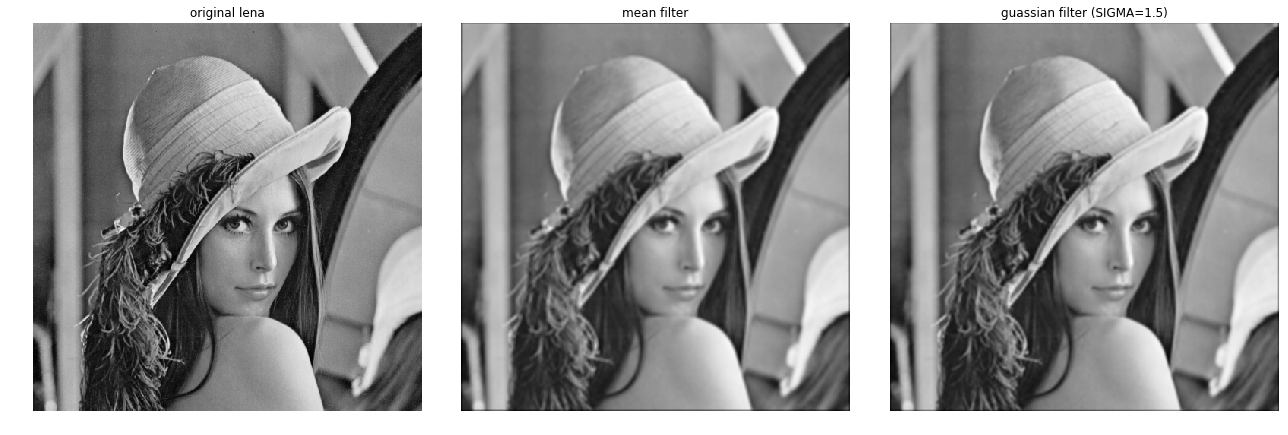

In [11]:
show_img_s([img, convolve(img, mean_kern(5)), convolve(img, gaussian_kern(5,1.5))],\
           ["original lena", "mean filter", "guassian filter (SIGMA=1.5)"])

### Unshark Masking
Cuando se hace referencia a UM, quiere decirse Unsharp Masking.

In [80]:
blurry_img = misc.imread("blurry_forest_2.jpg")[:,:,0]

In [81]:
def unsharp_masking(img, alpha, size = 3):
    ID = np.zeros((size,size)); ID[size/2,size/2] = 1
    KERN = np.array(ID - mean_kern(size))
    return img+alpha*convolve2d(img, KERN, mode="same")
#     return img + alpha*convolve2d(img, KERN, mode="same")
def naive_unsharp_masking(img, alpha, size=3):
    return img + alpha*(img - convolve(img, mean_kern(size)))


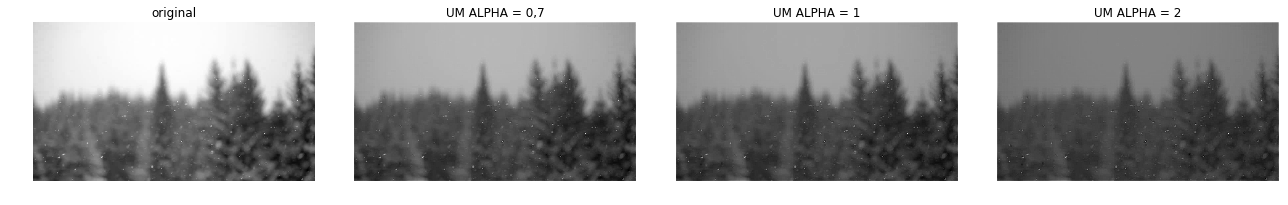

In [82]:
# mean_filtered_img = convolve2d(img_2, np.ones((3,3))*(1/float(9)), mode="same")
show_img_s([blurry_img, unsharp_masking(blurry_img, .7, size=5), unsharp_masking(blurry_img, 1, size=5), unsharp_masking(blurry_img, 2, size=5)],\
           ["original", "UM ALPHA = 0,7","UM ALPHA = 1", "UM ALPHA = 2" ])

In [ ]:
# Se asume p_p < p_s, y que IMG esta en uint8
def pep_salt_noise(img, p_p, p_s):
    IMG = np.copy(img)
    for i in range(len(IMG)):
        for j in range(len(IMG[0])):
            lottery = np.random.uniform()
            if lottery < p_p:
                # pepper
                IMG[i,j] = 0
            elif p_s < lottery:
                #salt
                IMG[i,j] = 255                
            else:
                #none
                continue    
    return IMG

In [ ]:
show_img(pep_salt_noise(img, .01,.99))

## Ejercicio 5

Notar que no se lidió con los borden en la implementación del filtro. La decisión fue tomada debido que al hacerlo, se debería usar una estimación de los datos que faltan a considerar ahí, o reducir la dimensión de la ventana que se toma en cuenta en los casos borde. De hacerlo, si dicha ventana tuviera alta concentración de *outliers*, se deterioraría la calidad final.

In [ ]:
def median_filter(I, dim):
    m = len(I); n = len(I[0])
    out = np.zeros((m,n))
    for i in range(0+dim//2, m-dim//2):
        for j in range(0+dim//2, n-dim//2):
            t = I[i-dim//2:i+dim//2+1, j-dim//2:j+dim//2+1]
            out[i,j] = np.median(t)
    return out

In [ ]:
plt.figure(figsize=(18,10)); plt.axis('off')
plt.imshow(median_filter(img, 5), cmap='gray')
plt.show()

## Ejercicio 7

In [ ]:
img = misc.imread('lena.png')

#### Roberts

In [ ]:
# Prewitt
Gx = [[-1,0,1],[-1,0,1],[-1,0,1]]
Gy = [[1,1,1],[0,0,0],[-1,-1,-1]]
img_x = convolve2d(img,Gx,mode='same')
img_y = convolve2d(img,Gy,mode='same')
img_mod = np.sqrt(np.power(img_x,2)+np.power(img_y,2))
show_img_s([img_x,img_y,img_mod])

#### Prewitt

In [14]:
# Prewitt
Gx = [[-1,0,1],[-1,0,1],[-1,0,1]]
Gy = [[1,1,1],[0,0,0],[-1,-1,-1]]
img_x = convolve2d(img,Gx,mode='same')
img_y = convolve2d(img,Gy,mode='same')
img_mod = np.sqrt(np.power(img_x,2)+np.power(img_y,2))
show_img_s([img_x,img_y,img_mod])

#### Sobel

In [ ]:
# Sobel
Gx = [[-1,0,1],[-2,0,2],[-1,0,1]]
Gy = [[1,2,1],[0,0,0],[-1,-2,-1]]
img_x = convolve2d(img,Gx,mode='same')
img_y = convolve2d(img,Gy,mode='same')
img_mod = np.sqrt(np.power(img_x,2)+np.power(img_y,2))
show_img_s([img_x,img_y,img_mod])